# Lead Scoring Predictor

In [1]:
import json
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from pandas.core.common import SettingWithCopyWarning

COLORS = sns.color_palette('muted')
FIGSIZE = (10,7)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
def predict_evaluate(predictor, X_train, y_train, X_test, y_test, response=False):
    """Predict and evaluate predictor."""
    y_test_predicted = predictor.predict(X_test)
    
    train_acc = predictor.score(X_train, y_train)
    test_acc = predictor.score(X_test, y_test)
    f1_s = f1_score(y_test, y_test_predicted)
    
    if response:
        return (train_acc, test_acc, f1_s)
    else:
        print(f"Predictor train accuracy: {train_acc:.3f}")
        print(f"Predictor test accuracy: {test_acc:.3f}")
        print(f"Predictor f1 score: {f1_s:.3f}")

        print(confusion_matrix(y_test, y_test_predicted))
        print(classification_report(y_test, y_test_predicted))

# 1. Analyse des données

In [3]:
quotes = pd.read_csv('data/long_quotes.csv')
logs = pd.read_csv('data/mixpanel.csv')

#### 1.1 Quotes analysis

In [4]:
quotes.head(3)

,long_quote_id,lead_id,country_code,first_utm_source,last_utm_source,has_been_proposed_formulas,has_chosen_formula,has_subscribed_online,submitted_at,effective_start_date,...,main_driver_age,main_driver_gender,main_driver_licence_age,main_driver_bonus,vehicle_age,vehicle_class,vehicle_group,vehicle_region,has_secondary_driver,has_subscribed
0,7527452923606463240,-1065398551916348537,FR,NaN,NaN,False,False,False,2021-09-01 18:18:19 UTC,2021-09-05,...,40-59,M,15+,064-084,03-05,I-K,31-32,Picardie,False,False
1,2676593580459190130,-3188174584045372774,FR,NaN,NaN,False,False,False,2021-09-01 12:29:25 UTC,2021-09-03,...,40-59,F,15+,050,10-14,I-K,29-30,Rhone-Alpes,True,False
2,-8181351603970286153,809161028469555575,FR,NaN,NaN,False,False,False,2021-09-01 03:52:34 UTC,2021-11-01,...,40-59,M,15+,100,00,O-R,35+,Champagne-Ardenne,True,False


In [5]:
quotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   long_quote_id               1215 non-null   int64  
 1   lead_id                     1215 non-null   int64  
 2   country_code                1215 non-null   object 
 3   first_utm_source            232 non-null    object 
 4   last_utm_source             232 non-null    object 
 5   has_been_proposed_formulas  1215 non-null   bool   
 6   has_chosen_formula          1215 non-null   bool   
 7   has_subscribed_online       1215 non-null   bool   
 8   submitted_at                1215 non-null   object 
 9   effective_start_date        1214 non-null   object 
 10  rbs_result                  50 non-null     object 
 11  provider                    1027 non-null   object 
 12  product_third_party         1027 non-null   object 
 13  product_intermediate        1027 

#### Duplicates rows in the quotes

In [6]:
quotes['long_quote_id'].value_counts()

 3193278899385012716    2
-2567510670073880055    2
-6207503491702107433    2
-8460876607405465288    1
-5823080703452367928    1
                       ..
-7247650444290653422    1
 5915931168270183226    1
 5511888581927997971    1
-3740565721924245756    1
-4400907979771225928    1
Name: long_quote_id, Length: 1212, dtype: int64

In [7]:
quotes = quotes.drop_duplicates()

In [8]:
quotes['long_quote_id'].value_counts()

-8460876607405465288    1
-8999035888099581211    1
 2676593580459190130    1
-2080494545874085595    1
-7023964638711598666    1
                       ..
 5915931168270183226    1
 5511888581927997971    1
-3740565721924245756    1
 5851731705011274421    1
-4400907979771225928    1
Name: long_quote_id, Length: 1212, dtype: int64

In [9]:
quotes['lead_id'].value_counts()

 6007475069273989421    12
 707106108801747155      6
 2985704236974667725     6
 7443518922044095226     5
 6417788977143244366     5
                        ..
 4864065490631433717     1
-3314367315040936652     1
 3837605510687758841     1
 3350398049064773035     1
-2208476976128241344     1
Name: lead_id, Length: 1058, dtype: int64

In [10]:
df_gb = quotes.groupby(['lead_id'])['long_quote_id'].agg('count').reset_index()

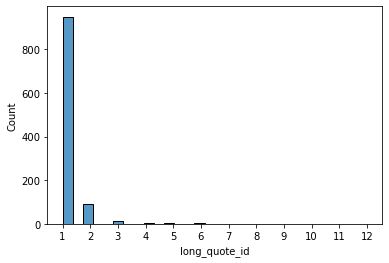

In [11]:
sns.histplot(data=df_gb, x='long_quote_id', bins=30)
_ = plt.xticks([i for i in range(1,13)])

#### Feature has_subscribed is unbalanced

False    1123
True       89
Name: has_subscribed, dtype: int64


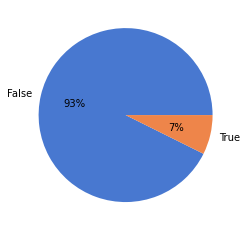

In [12]:
print(quotes['has_subscribed'].value_counts())

plt.pie(quotes['has_subscribed'].value_counts(), labels=set(quotes['has_subscribed']), colors=COLORS, autopct='%.0f%%')
plt.show()

#### Most of subscription comes from Customer Care

False    72
True     17
Name: has_subscribed_online, dtype: int64


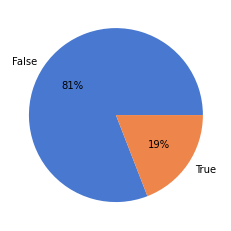

In [13]:
quotes_subscribed = quotes[quotes['has_subscribed']==True]
print(quotes_subscribed['has_subscribed_online'].value_counts())

plt.pie(quotes_subscribed['has_subscribed_online'].value_counts(), labels=set(quotes_subscribed['has_subscribed_online']), colors=COLORS, autopct='%.0f%%')
plt.show()

#### 1.2 Logs analysis

In [14]:
logs.head(5)

,time,page_view,mp_os,mp_browser,utm_source,insurance_subscription,mp_event_name
0,2021-09-01 18:31:02,"{""page_collection"":""website"",""page_path"":""/ass...",Android,Android Mobile,NaN,"{""lead_quote_status"": ""NoGo"", ""nogo_reason"": ""...",Insurance - Complete Insurance Long Quote
1,2021-09-01 18:31:02,"{""page_collection"":""website"",""page_path"":""/ass...",Android,Android Mobile,NaN,"{""lead_quote_status"": ""NoGo"", ""nogo_reason"": ""...",Insurance - Complete Insurance Long Quote
2,2021-09-01 14:15:49,"{""page_collection"":""website"",""page_path"":""/ass...",Windows,Firefox,google,"{""broker_name"": null, ""category_quoted_tiers"":...",Insurance - Complete Insurance Long Quote
3,2021-09-01 14:16:29,"{""page_collection"":""website"",""page_path"":""/ass...",Windows,Firefox,google,"{""broker_name"": null, ""long_quote_id"": -716719...",Insurance - Customize Insurance Contract
4,2021-09-01 14:16:29,"{""page_collection"":""website"",""page_path"":""/ass...",Windows,Firefox,google,"{""broker_name"": null, ""long_quote_id"": -716719...",Insurance - Customize Insurance Contract


In [15]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9410 entries, 0 to 9409
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   time                    9410 non-null   object
 1   page_view               9410 non-null   object
 2   mp_os                   9410 non-null   object
 3   mp_browser              9410 non-null   object
 4   utm_source              6830 non-null   object
 5   insurance_subscription  9410 non-null   object
 6   mp_event_name           9410 non-null   object
dtypes: object(7)
memory usage: 514.7+ KB


In [16]:
logs_parsed = pd.io.json.json_normalize(logs['insurance_subscription'].apply(json.loads))

<ipython-input-16-81a4abc42ea3>:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  logs_parsed = pd.io.json.json_normalize(logs['insurance_subscription'].apply(json.loads))


In [17]:
logs_parsed.head()

,lead_quote_status,nogo_reason,broker_name,category_quoted_tiers,long_quote_id,product_name,product_type,warranties,lead_id,category_started,vehicle_search_method,contract_id,start_date
0,NoGo,Tarification impossible () EXCLUSION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NoGo,Tarification impossible () EXCLUSION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Go,NaN,None,autre,-7.167195e+18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,None,NaN,-7.167195e+18,autre,third_party,[],NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,None,NaN,-7.167195e+18,autre,third_party,[],NaN,NaN,NaN,NaN,NaN


In [18]:
logs_parsed = logs_parsed[logs_parsed['long_quote_id'].notnull()]
logs_parsed['long_quote_id'] = logs_parsed['long_quote_id'].astype('Int64').astype(str)

# 2. Lead scoring predictor

### Data prep

In [19]:
quotes.head(3)

,long_quote_id,lead_id,country_code,first_utm_source,last_utm_source,has_been_proposed_formulas,has_chosen_formula,has_subscribed_online,submitted_at,effective_start_date,...,main_driver_age,main_driver_gender,main_driver_licence_age,main_driver_bonus,vehicle_age,vehicle_class,vehicle_group,vehicle_region,has_secondary_driver,has_subscribed
0,7527452923606463240,-1065398551916348537,FR,NaN,NaN,False,False,False,2021-09-01 18:18:19 UTC,2021-09-05,...,40-59,M,15+,064-084,03-05,I-K,31-32,Picardie,False,False
1,2676593580459190130,-3188174584045372774,FR,NaN,NaN,False,False,False,2021-09-01 12:29:25 UTC,2021-09-03,...,40-59,F,15+,050,10-14,I-K,29-30,Rhone-Alpes,True,False
2,-8181351603970286153,809161028469555575,FR,NaN,NaN,False,False,False,2021-09-01 03:52:34 UTC,2021-11-01,...,40-59,M,15+,100,00,O-R,35+,Champagne-Ardenne,True,False


In [20]:
quotes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1212 entries, 0 to 1214
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   long_quote_id               1212 non-null   int64  
 1   lead_id                     1212 non-null   int64  
 2   country_code                1212 non-null   object 
 3   first_utm_source            229 non-null    object 
 4   last_utm_source             229 non-null    object 
 5   has_been_proposed_formulas  1212 non-null   bool   
 6   has_chosen_formula          1212 non-null   bool   
 7   has_subscribed_online       1212 non-null   bool   
 8   submitted_at                1212 non-null   object 
 9   effective_start_date        1211 non-null   object 
 10  rbs_result                  50 non-null     object 
 11  provider                    1025 non-null   object 
 12  product_third_party         1025 non-null   object 
 13  product_intermediate        1025 

In [21]:
# To consider ? : first_utm_source, last_utm_source, submitted_at, effective_start_date?, 
quotes_categorical_cols = ['has_been_proposed_formulas', 'has_chosen_formula', 'provider', 'product_third_party', 
                           'product_intermediate', 'product_all_risks', 'annual_price_third_party', 
                           'annual_price_intermediate', 'annual_price_all_risks', 'chosen_formula', 'chosen_product',
                           'main_driver_age', 'main_driver_gender', 'main_driver_licence_age', 'main_driver_bonus',
                           'vehicle_age', 'vehicle_class', 'vehicle_group', 'vehicle_region', 'has_secondary_driver']

quotes_target_col = 'has_subscribed'

In [22]:
X_quotes = quotes[quotes_categorical_cols]
y_quotes = quotes[quotes_target_col]
y_quotes = np.where(y_quotes==False, 0, 1)

In [23]:
y_quotes

array([0, 0, 0, ..., 0, 1, 1])

In [24]:
def clean_preprocess(df):
    """Replace missing values and get dumies for cat variables."""
    # provider, product_third_party, product_intermediate, product_all_risks,
    # annual_price_third_party, annual_price_intermediate, annual_price_all_risks: replace by most frequent
    # chosen_formula, chosen_product : replace nans by 'not clicked'

    # Replacing missing values by most frequent
    df['provider'] = df['provider'].fillna(df['provider'].value_counts().idxmax())
    df['product_third_party'] = df['product_third_party'].fillna(df['product_third_party'].value_counts().idxmax())
    df['product_intermediate'] = df['product_intermediate'].fillna(df['product_intermediate'].value_counts().idxmax())
    df['product_all_risks'] = df['product_all_risks'].fillna(df['product_all_risks'].value_counts().idxmax())
    df['annual_price_third_party'] = df['annual_price_third_party'].fillna(df['annual_price_third_party'].value_counts().idxmax())
    df['annual_price_intermediate'] = df['annual_price_intermediate'].fillna(df['annual_price_intermediate'].value_counts().idxmax())
    df['annual_price_all_risks'] = df['annual_price_all_risks'].fillna(df['annual_price_all_risks'].value_counts().idxmax())
    
    # Replacing missing values by 'None'
    df['chosen_formula'] = df['chosen_formula'].fillna('None')
    df['chosen_product'] = df['chosen_product'].fillna('None')
    
    # Replacing missing values by most frequent
    df['vehicle_class'] = df['vehicle_class'].fillna(df['vehicle_class'].value_counts().idxmax())
    df['vehicle_group'] = df['vehicle_group'].fillna(df['vehicle_group'].value_counts().idxmax())
    
    # Categorical encoding
    df_dummies = pd.get_dummies(df, drop_first=True)

    return df_dummies

In [25]:
X_quotes = clean_preprocess(X_quotes)

In [26]:
X_quotes_train, X_quotes_test, y_quotes_train, y_quotes_test = train_test_split(X_quotes, y_quotes,
                                                                               train_size=0.7, test_size=0.3,
                                                                               random_state=0)

### Logistic regression
https://www.kaggle.com/code/ashydv/lead-scoring-logistic-regression

In [27]:
lr_predictor = LogisticRegression(random_state=0, class_weight='balanced')

lr_predictor = lr_predictor.fit(X_quotes_train, y_quotes_train)

In [28]:
predict_evaluate(lr_predictor, X_quotes_train, y_quotes_train, X_quotes_test, y_quotes_test)

Predictor train accuracy: 0.815
Predictor test accuracy: 0.786
Predictor f1 score: 0.381
[[262  72]
 [  6  24]]
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       334
           1       0.25      0.80      0.38        30

    accuracy                           0.79       364
   macro avg       0.61      0.79      0.63       364
weighted avg       0.92      0.79      0.83       364



### Random forest
https://link.medium.com/0HeoU8Qslsb

In [29]:
# Random Forest
rf_predictor = RandomForestClassifier(random_state=0, class_weight='balanced')

rf_predictor = rf_predictor.fit(X_quotes_train, y_quotes_train)

In [30]:
predict_evaluate(rf_predictor, X_quotes_train, y_quotes_train, X_quotes_test, y_quotes_test)

Predictor train accuracy: 1.000
Predictor test accuracy: 0.953
Predictor f1 score: 0.622
[[333   1]
 [ 16  14]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       334
           1       0.93      0.47      0.62        30

    accuracy                           0.95       364
   macro avg       0.94      0.73      0.80       364
weighted avg       0.95      0.95      0.95       364



### Logistic Regression v2.0 : Using Pipelines

In [31]:
X_quotes = quotes[quotes_categorical_cols]
y_quotes = quotes[quotes_target_col]
y_quotes = np.where(y_quotes==False, 0, 1)

In [32]:
X_quotes_train, X_quotes_test, y_quotes_train, y_quotes_test = train_test_split(X_quotes, y_quotes,
                                                                               train_size=0.7, test_size=0.3,
                                                                               random_state=0)

In [33]:
imputer = SimpleImputer(strategy="most_frequent")
categorical_encoder = OneHotEncoder(handle_unknown='ignore')

categorical_pipeline = Pipeline(
    [("imputer", imputer), ("encoder", categorical_encoder)]
)

preprocess_pipeline = ColumnTransformer(transformers=[
    ("category", categorical_pipeline, quotes_categorical_cols)
])

In [34]:
lr_pipeline = Pipeline(
    [
        ("preprocess", preprocess_pipeline),
        ("classifier", LogisticRegression(random_state=0, class_weight='balanced')),
    ]
)
lr_pipeline = lr_pipeline.fit(X_quotes_train, y_quotes_train)

C:\Work\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
predict_evaluate(lr_pipeline, X_quotes_train, y_quotes_train, X_quotes_test, y_quotes_test)

Predictor train accuracy: 0.810
Predictor test accuracy: 0.791
Predictor f1 score: 0.377
[[265  69]
 [  7  23]]
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       334
           1       0.25      0.77      0.38        30

    accuracy                           0.79       364
   macro avg       0.61      0.78      0.63       364
weighted avg       0.91      0.79      0.83       364



### Random Forest v2.0 : Using Pipelines, GridSearch and feature importance

In [36]:
imputer = SimpleImputer(strategy="most_frequent")
categorical_encoder = OneHotEncoder(handle_unknown='ignore')

categorical_pipeline = Pipeline(
    [("imputer", imputer), ("encoder", categorical_encoder)]
)

preprocess_pipeline = ColumnTransformer(transformers=[
    ("category", categorical_pipeline, quotes_categorical_cols)
])

In [37]:
rf_pipeline = Pipeline(
    [
        ("preprocess", preprocess_pipeline),
        ("classifier", RandomForestClassifier(random_state=0, class_weight='balanced')),
    ]
)
rf_pipeline = rf_pipeline.fit(X_quotes_train, y_quotes_train)

In [38]:
predict_evaluate(rf_pipeline, X_quotes_train, y_quotes_train, X_quotes_test, y_quotes_test)

Predictor train accuracy: 1.000
Predictor test accuracy: 0.956
Predictor f1 score: 0.636
[[334   0]
 [ 16  14]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       334
           1       1.00      0.47      0.64        30

    accuracy                           0.96       364
   macro avg       0.98      0.73      0.81       364
weighted avg       0.96      0.96      0.95       364



In [39]:
rf_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocess', 'classifier', 'preprocess__n_jobs', 'preprocess__remainder', 'preprocess__sparse_threshold', 'preprocess__transformer_weights', 'preprocess__transformers', 'preprocess__verbose', 'preprocess__category', 'preprocess__category__memory', 'preprocess__category__steps', 'preprocess__category__verbose', 'preprocess__category__imputer', 'preprocess__category__encoder', 'preprocess__category__imputer__add_indicator', 'preprocess__category__imputer__copy', 'preprocess__category__imputer__fill_value', 'preprocess__category__imputer__missing_values', 'preprocess__category__imputer__strategy', 'preprocess__category__imputer__verbose', 'preprocess__category__encoder__categories', 'preprocess__category__encoder__drop', 'preprocess__category__encoder__dtype', 'preprocess__category__encoder__handle_unknown', 'preprocess__category__encoder__sparse', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion

In [40]:
rf_param_grid = { 
    'classifier__n_estimators': [25, 50, 100],
    'classifier__max_depth': [4, 5, 6, 7],
    'classifier__min_samples_split': [2, 3, 4]
}

In [41]:
rf_pipeline_gridsearch = GridSearchCV(estimator=rf_pipeline, param_grid=rf_param_grid, cv=5)
rf_pipeline_gridsearch = rf_pipeline_gridsearch.fit(X_quotes_train, y_quotes_train)

In [42]:
rf_pipeline_gridsearch.best_params_

{'classifier__max_depth': 7,
 'classifier__min_samples_split': 4,
 'classifier__n_estimators': 100}

In [43]:
rf_pipeline_best = Pipeline(
    [
        ("preprocess", preprocess_pipeline),
        ("classifier", RandomForestClassifier(random_state=0, class_weight='balanced',
                                              max_depth=rf_pipeline_gridsearch.best_params_['classifier__max_depth'], 
                                              min_samples_split=rf_pipeline_gridsearch.best_params_['classifier__min_samples_split'], 
                                              n_estimators=rf_pipeline_gridsearch.best_params_['classifier__n_estimators']))
    ]
)
rf_pipeline_best = rf_pipeline_best.fit(X_quotes_train, y_quotes_train)

In [44]:
predict_evaluate(rf_pipeline_best, X_quotes_train, y_quotes_train, X_quotes_test, y_quotes_test)

Predictor train accuracy: 0.889
Predictor test accuracy: 0.865
Predictor f1 score: 0.462
[[294  40]
 [  9  21]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       334
           1       0.34      0.70      0.46        30

    accuracy                           0.87       364
   macro avg       0.66      0.79      0.69       364
weighted avg       0.92      0.87      0.89       364



#### Score repartition

In [45]:
y_pred = rf_pipeline_best.predict_proba(X_quotes_test)

In [46]:
df_pred = pd.DataFrame(y_pred, columns = ['neg_score','pos_score'])

In [47]:
df_pred.head()

,neg_score,pos_score
0,0.988412,0.011588
1,0.570049,0.429951
2,0.637114,0.362886
3,0.821664,0.178336
4,0.703515,0.296485


<AxesSubplot:xlabel='pos_score', ylabel='Count'>

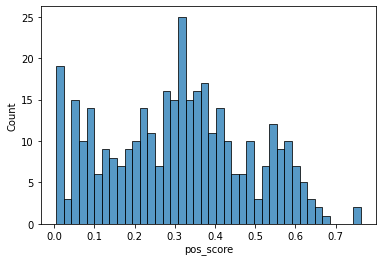

In [48]:
sns.histplot(data=df_pred, x="pos_score", bins=40)

#### Feature importance

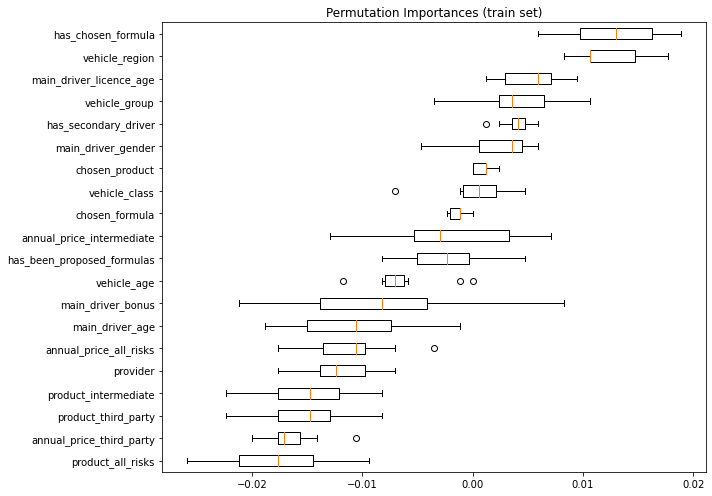

In [49]:
result = permutation_importance(rf_pipeline_best, X_quotes_train, y_quotes_train, n_repeats=10,
                                random_state=0, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.boxplot(result.importances[sorted_idx].T, 
           vert=False, labels=X_quotes_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

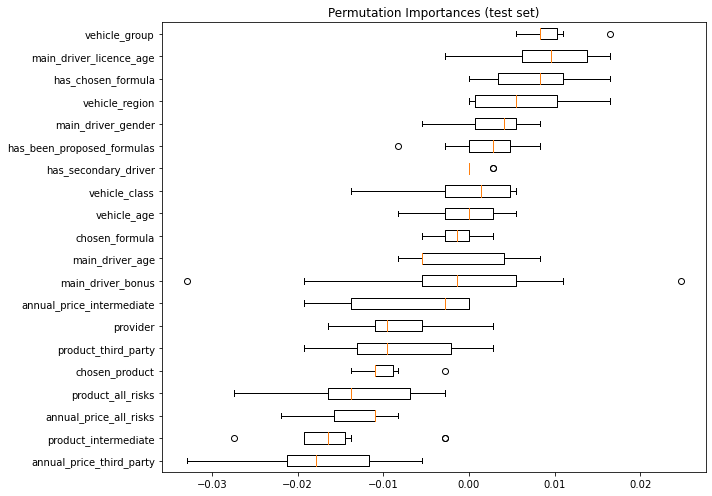

In [50]:
result = permutation_importance(rf_pipeline_best, X_quotes_test, y_quotes_test, n_repeats=10,
                                random_state=0, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.boxplot(result.importances[sorted_idx].T, 
           vert=False, labels=X_quotes_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [51]:
train_fi_list = X_quotes_train.columns[sorted_idx]
test_fi_list = X_quotes_test.columns[sorted_idx]

In [52]:
test_fi_list

Index(['annual_price_third_party', 'product_intermediate',
       'annual_price_all_risks', 'product_all_risks', 'chosen_product',
       'product_third_party', 'provider', 'annual_price_intermediate',
       'main_driver_bonus', 'main_driver_age', 'chosen_formula', 'vehicle_age',
       'vehicle_class', 'has_secondary_driver', 'has_been_proposed_formulas',
       'main_driver_gender', 'vehicle_region', 'has_chosen_formula',
       'main_driver_licence_age', 'vehicle_group'],
      dtype='object')

In [53]:
# FIXME : graph to show how features go up and down in ranking

### Support Vector Machine

In [54]:
svm_pipeline = Pipeline(
    [
        ("preprocess", preprocess_pipeline),
        ("classifier", svm.SVC(class_weight='balanced')),
    ]
)
svm_pipeline = svm_pipeline.fit(X_quotes_train, y_quotes_train)

In [55]:
predict_evaluate(svm_pipeline, X_quotes_train, y_quotes_train, X_quotes_test, y_quotes_test)

Predictor train accuracy: 0.894
Predictor test accuracy: 0.852
Predictor f1 score: 0.438
[[289  45]
 [  9  21]]
              precision    recall  f1-score   support

           0       0.97      0.87      0.91       334
           1       0.32      0.70      0.44        30

    accuracy                           0.85       364
   macro avg       0.64      0.78      0.68       364
weighted avg       0.92      0.85      0.88       364



### Result recap

In [56]:
def compare_model_perf(dict_models, X_quotes_train, y_quotes_train, X_quotes_test, y_quotes_test):
    """Compare model performances."""
    l_main = []
    for key, model in dict_models.items():
        (train_acc, test_acc, f1_score) = predict_evaluate(model, X_quotes_train, y_quotes_train, 
                                                           X_quotes_test, y_quotes_test, response=True)
        l_main.append([key, train_acc, test_acc, f1_score])
    return l_main

In [57]:
scores = compare_model_perf({"logistic_regression": lr_pipeline, 
                    "random_forest": rf_pipeline_best,
                    "svm": svm_pipeline},
                   X_quotes_train, y_quotes_train, X_quotes_test, y_quotes_test)

In [58]:
df_scores = pd.DataFrame(scores, columns = ['model_name', 'train_acc', 'test_acc', 'f1_score'])

In [59]:
df_scores

,model_name,train_acc,test_acc,f1_score
0,logistic_regression,0.810142,0.791209,0.377049
1,random_forest,0.889151,0.865385,0.461538
2,svm,0.893868,0.851648,0.437500


<AxesSubplot:xlabel='model_name'>

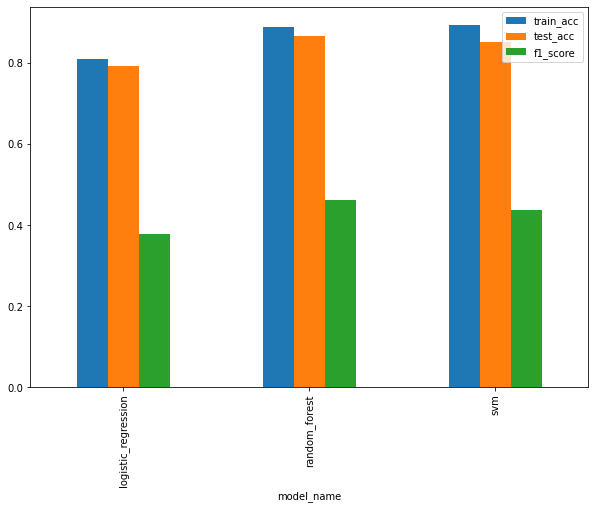

In [60]:
df_scores.plot(x="model_name", y=["train_acc", "test_acc", "f1_score"], kind="bar", figsize=FIGSIZE)

### PKL export best model

In [61]:
filename = 'rf_pipeline.pkl'
pickle.dump(rf_pipeline, open(filename, 'wb'))

# 3. Données additionnelles

- **Campagnes Marketing :** Avoir les data des clics / open rate
- **Historiques des appels téléphoniques :** Avoir les données des appels pour voir la corrélation entre les relances téléphoniques et la conversion en client
- **Browsing logs :** Avoir le nombre de fois qu'ils sont venus sur le site + la durée des sessions

# 4. Les applications

- **Campagnes marketing :** Target les lead avec le score le plus haut avec des campagnes marketing pour réduire la pression commerciale et optimiser les campagnes.
- **Customer Care :** Outils Customer Care qui demandent le score du lead en temps réel pour une meilleure compréhension du lead.
- **Sales/CC :** Relances téléphoniques priorisées en fonction du score du lead.

# (5. Les pistes d'améliorations / next steps)

- Améliorer le feature engineering :
    - Ajouter le nombre de devis réalisés par lead
    - Regrouper des valeurs similaires sur des features avec de nombreuses valeurs
    - Passer les features initallement numériques en numérique : main_driver_licence_age ; main_driver_bonus
    - Prendre plus de temps pour étudier chaque feature
- Ajouter les données de mixpanel.csv pour enrichir les données
- Mieux étudier les résultats des modèles pour mieux les évaluer :
    - Faire intervenir d'autres métriques
    - Savoir qu'est-ce qui est le plus dommageable : avoir plus de Faux Positif ou de Faux Négatif ? Instinctivement je dirais que avoir des Faux Positif mois grave que Faux Négatif car peu de données.
- Améliorer la mise en production :
    - Utiliser un modèle registry : dvc
    - Investiguer pour améliorer les performances de l'API
    - Ajouter un path à l'API qui permet d'avoir accès aux scores précalculés sur BigQuery